In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg2subset/dataset/val/n000463/0023_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0287_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0185_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0407_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0181_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0104_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0305_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0040_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0050_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0035_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0048_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0147_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0132_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0336_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0179_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0230_01.jpg
/kaggle/input/vgg2subset/dataset/val/n000463/0024_01.jpg
/kaggle/input/vgg2subset/datase

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc,confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [3]:
train_dir = "/kaggle/input/vgg2subset/dataset/train"
val_dir = "/kaggle/input/vgg2subset/dataset/test"
test_dir = "/kaggle/input/vgg2subset/dataset/val"

In [4]:
input_shape = (224, 224, 3)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [5]:
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 23223 images belonging to 80 classes.
Found 2973 images belonging to 80 classes.
Found 2875 images belonging to 80 classes.


In [7]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

In [9]:
from tensorflow.keras.layers import BatchNormalization

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)  # Fully connected layer with L2 regularization
x = BatchNormalization()(x)  # Normalization
x = Dropout(0.5)(x)  # Dropout

x = Dense(512, activation='relu', kernel_regularizer='l2')(x)  # Additional dense layer
x = BatchNormalization()(x)  # Normalization
x = Dropout(0.3)(x)  # Dropout with reduced rate

predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer


In [10]:
# SAdd Custom Classifier
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Train for 10+20 epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734588998.908098      84 service.cc:145] XLA service 0x7bc3d40026e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734588998.908208      84 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/725 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.0078 - loss: 5.2142       

I0000 00:00:1734589012.396511      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


725/725 ━━━━━━━━━━━━━━━━━━━━ 421s 540ms/step - accuracy: 0.0763 - loss: 4.0121 - val_accuracy: 0.2768 - val_loss: 2.8652
Epoch 2/10
  1/725 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.3125 - loss: 3.1018

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


725/725 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3125 - loss: 3.1018 - val_accuracy: 0.2069 - val_loss: 3.0000
Epoch 3/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 270s 368ms/step - accuracy: 0.2052 - loss: 3.1261 - val_accuracy: 0.3584 - val_loss: 2.5021
Epoch 4/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - accuracy: 0.3438 - loss: 2.7637 - val_accuracy: 0.2759 - val_loss: 2.5523
Epoch 5/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 267s 364ms/step - accuracy: 0.2720 - loss: 2.8545 - val_accuracy: 0.3916 - val_loss: 2.3640
Epoch 6/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 99us/step - accuracy: 0.2188 - loss: 3.4813 - val_accuracy: 0.2759 - val_loss: 2.5371
Epoch 7/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 265s 362ms/step - accuracy: 0.2845 - loss: 2.7602 - val_accuracy: 0.4202 - val_loss: 2.2562
Epoch 8/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 97us/step - accuracy: 0.2812 - loss: 2.4054 - val_accuracy: 0.5517 - val_loss: 2.0938
Epoch 9/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 265s 362ms/step - accuracy: 0.3076 - loss: 2.6627 - val_acc

In [14]:
# Fine-tune the Model
# Unfreeze the last 50 layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [15]:
# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [16]:
# Additional fine-tuning epochs
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/15
725/725 ━━━━━━━━━━━━━━━━━━━━ 313s 387ms/step - accuracy: 0.2356 - loss: 3.1388 - val_accuracy: 0.4266 - val_loss: 2.2261
Epoch 2/15
725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2500 - loss: 3.1580 - val_accuracy: 0.4828 - val_loss: 1.9537
Epoch 3/15
725/725 ━━━━━━━━━━━━━━━━━━━━ 264s 361ms/step - accuracy: 0.3190 - loss: 2.6320 - val_accuracy: 0.4521 - val_loss: 2.1069
Epoch 4/15
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - accuracy: 0.4062 - loss: 2.3761 - val_accuracy: 0.3103 - val_loss: 2.2912
Epoch 5/15
725/725 ━━━━━━━━━━━━━━━━━━━━ 262s 357ms/step - accuracy: 0.3471 - loss: 2.5048 - val_accuracy: 0.4616 - val_loss: 2.0500
Epoch 6/15
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 98us/step - accuracy: 0.3438 - loss: 2.4289 - val_accuracy: 0.4483 - val_loss: 1.9418
Epoch 7/15
725/725 ━━━━━━━━━━━━━━━━━━━━ 267s 365ms/step - accuracy: 0.3646 - loss: 2.4424 - val_accuracy: 0.4738 - val_loss: 2.0021
Epoch 8/15
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - accuracy: 0.2188 - loss: 2.808

In [17]:

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 314ms/step - accuracy: 0.4109 - loss: 2.2017
Test Accuracy: 48.31%


In [18]:
# Save the Model
model.save("celebrity_recognition_model.h5")

In [19]:
#  Predict on Test Data
test_generator.reset()  # Reset generator to avoid any issues
y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(y_pred_prob, axis=1)  # Get class predictions

90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step


In [20]:
# Get True Labels
y_true = test_generator.classes  # Ground truth labels
class_labels = list(test_generator.class_indices.keys()) # Class names

In [21]:
# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

     n000421       0.39      0.24      0.30        38
     n000422       0.20      0.22      0.21        41
     n000423       0.00      0.00      0.00        22
     n000424       0.17      0.05      0.08        20
     n000425       0.29      0.27      0.28        45
     n000426       0.29      0.55      0.38        40
     n000427       0.66      0.87      0.75        31
     n000428       0.39      0.32      0.35        37
     n000429       0.39      0.51      0.44        49
     n000430       0.52      0.57      0.54        23
     n000431       0.50      0.08      0.14        25
     n000432       0.50      0.28      0.36        25
     n000433       0.71      0.95      0.82        21
     n000434       0.50      0.64      0.56        47
     n000435       0.65      0.74      0.69        42
     n000436       0.50      0.35      0.41        20
     n000437       0.00      0.00      0.00        17
    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC Score (Micro): 0.9623


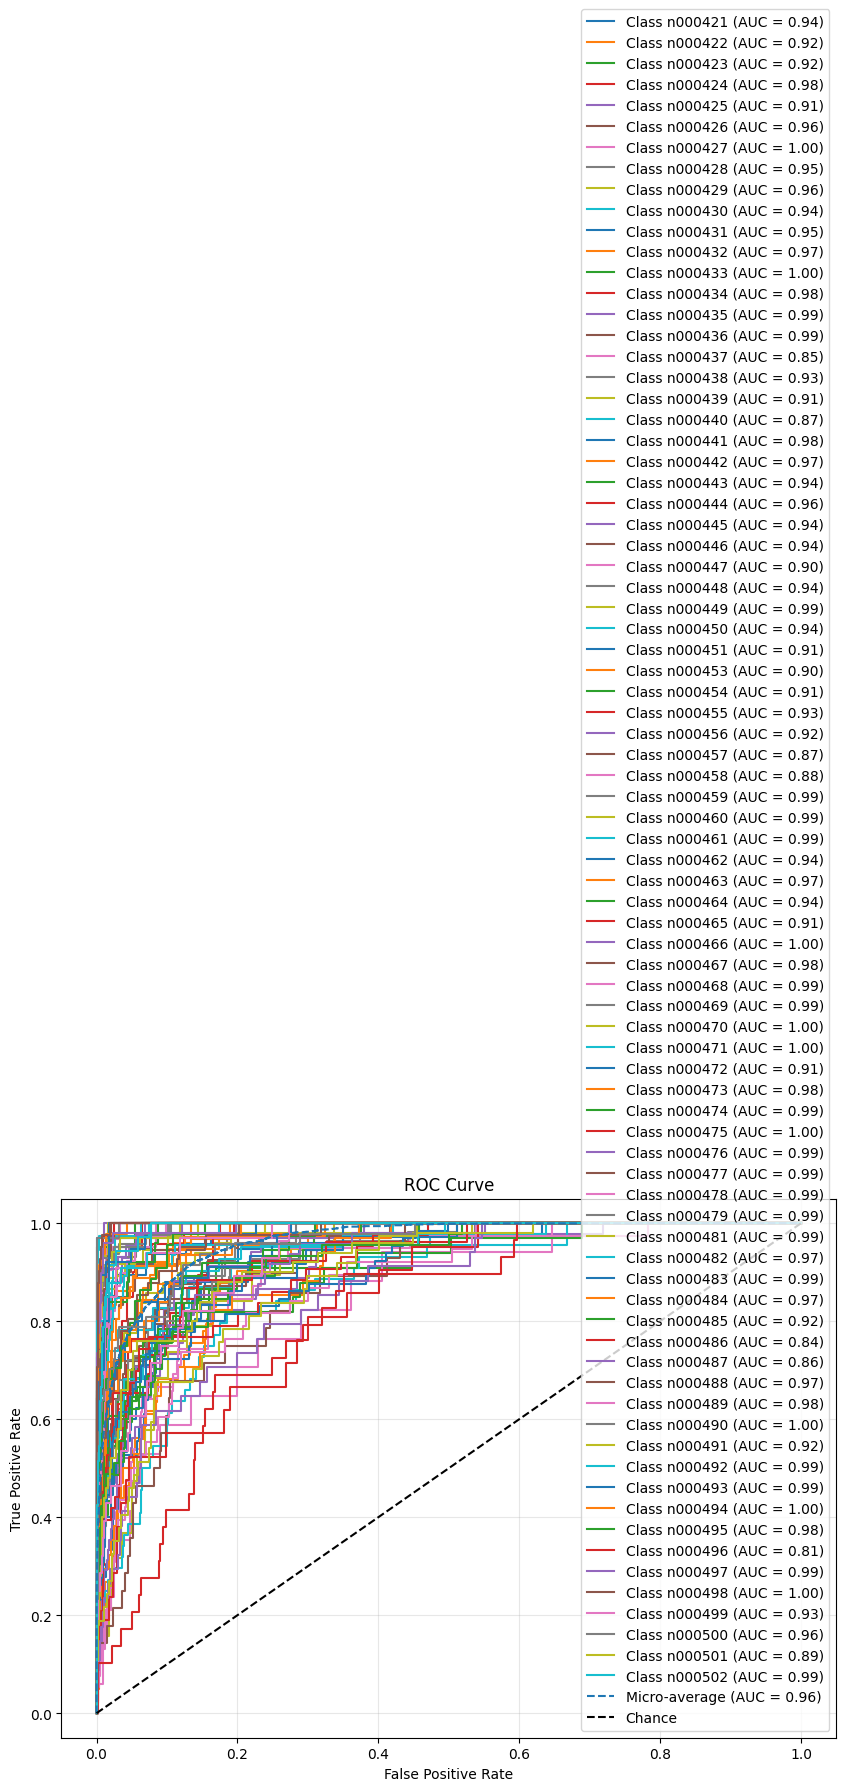

In [22]:

# Calculate ROC-AUC
# Convert y_true to one-hot encoding
y_true_one_hot = to_categorical(y_true, num_classes=len(class_labels))

# Calculate the micro-average ROC AUC
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="micro")
print(f"ROC AUC Score (Micro): {roc_auc:.4f}")

#Plot ROC Curve
fpr = {}
tpr = {}
roc_auc_dict = {}

# Compute ROC for each class
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc_dict["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_labels[i]} (AUC = {roc_auc_dict[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc_dict['micro']:.2f})", linestyle="--")

# Plot random chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step


<Figure size 8000x8000 with 0 Axes>

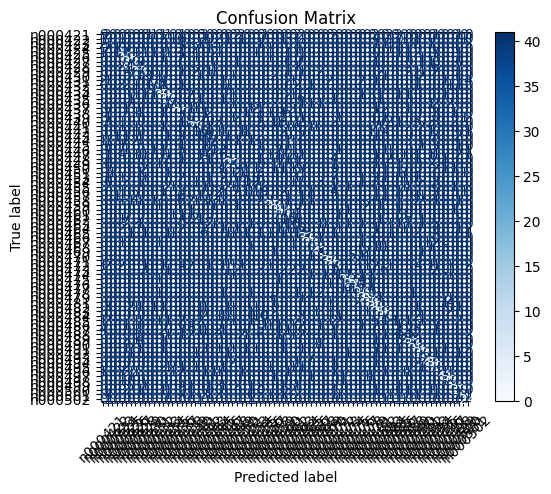

In [23]:
# Predict class probabilities
y_pred_probs = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

#  Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true class labels from the test generator
y_true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
class_labels = list(test_generator.class_indices.keys())  # Class names

#  Plot the confusion matrix
plt.figure(figsize=(80, 80))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [24]:
for i, class_label in enumerate(class_labels):
    cm_one_vs_all = confusion_matrix((y_true_classes == i).astype(int), (y_pred_classes == i).astype(int))
    print(f"Confusion Matrix for Class {class_label}:")
    print(cm_one_vs_all)

Confusion Matrix for Class n000421:
[[2823   14]
 [  29    9]]
Confusion Matrix for Class n000422:
[[2798   36]
 [  32    9]]
Confusion Matrix for Class n000423:
[[2852    1]
 [  22    0]]
Confusion Matrix for Class n000424:
[[2850    5]
 [  19    1]]
Confusion Matrix for Class n000425:
[[2800   30]
 [  33   12]]
Confusion Matrix for Class n000426:
[[2781   54]
 [  18   22]]
Confusion Matrix for Class n000427:
[[2830   14]
 [   4   27]]
Confusion Matrix for Class n000428:
[[2819   19]
 [  25   12]]
Confusion Matrix for Class n000429:
[[2787   39]
 [  24   25]]
Confusion Matrix for Class n000430:
[[2840   12]
 [  10   13]]
Confusion Matrix for Class n000431:
[[2848    2]
 [  23    2]]
Confusion Matrix for Class n000432:
[[2843    7]
 [  18    7]]
Confusion Matrix for Class n000433:
[[2846    8]
 [   1   20]]
Confusion Matrix for Class n000434:
[[2798   30]
 [  17   30]]
Confusion Matrix for Class n000435:
[[2816   17]
 [  11   31]]
Confusion Matrix for Class n000436:
[[2848    7]
 [  13

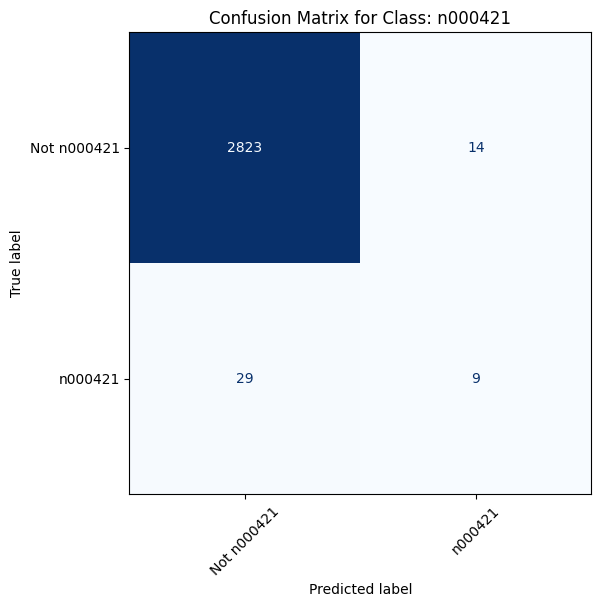

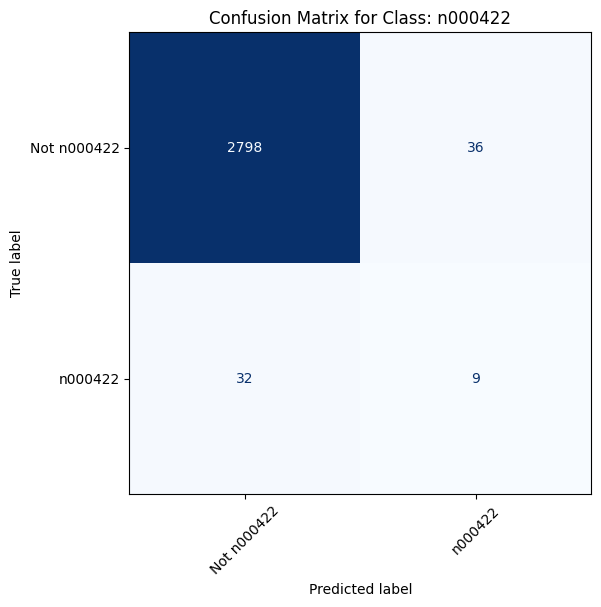

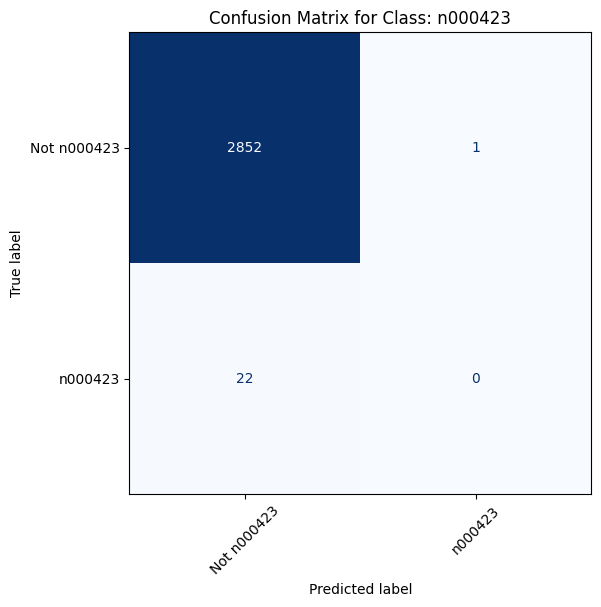

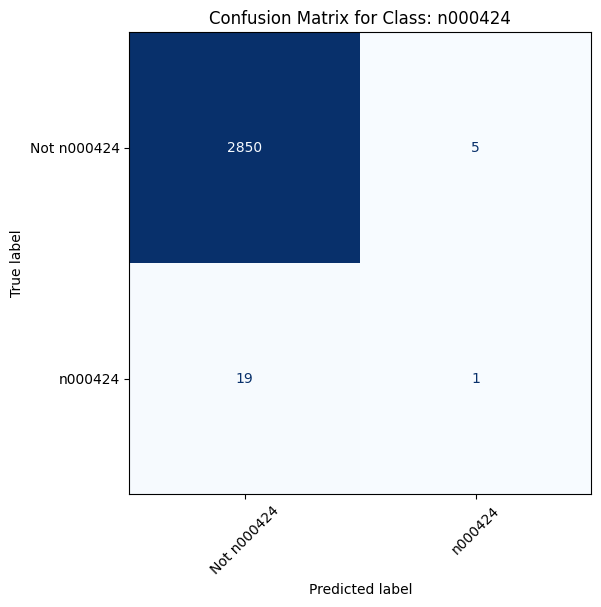

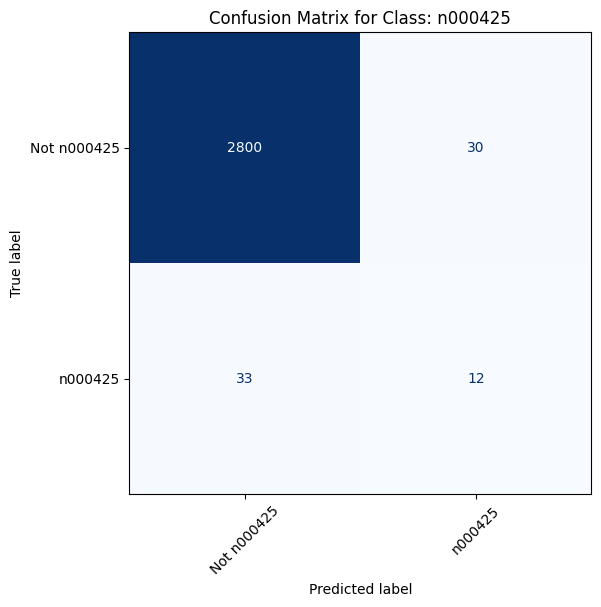

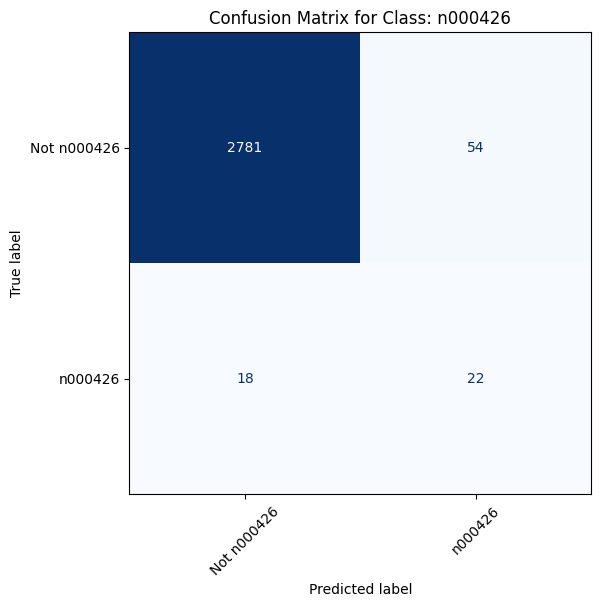

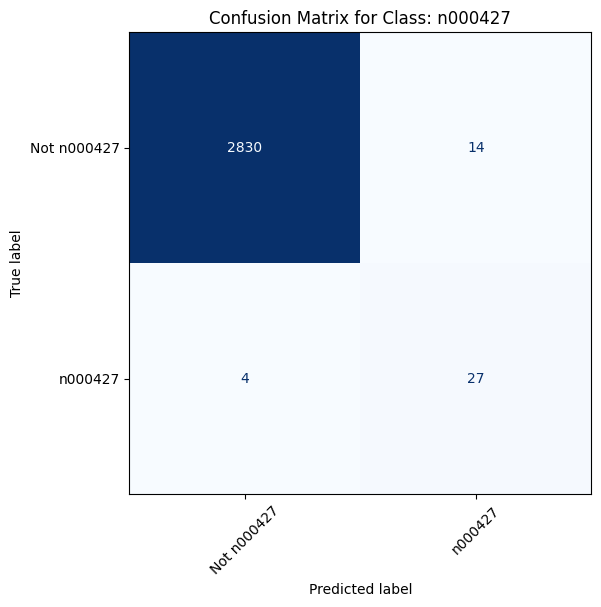

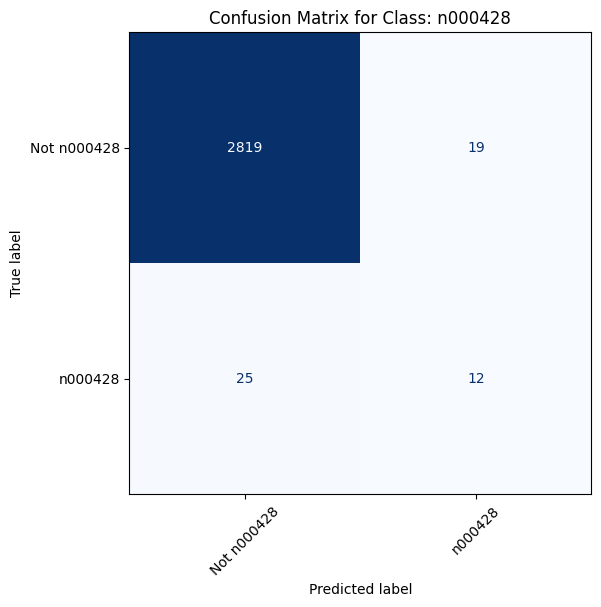

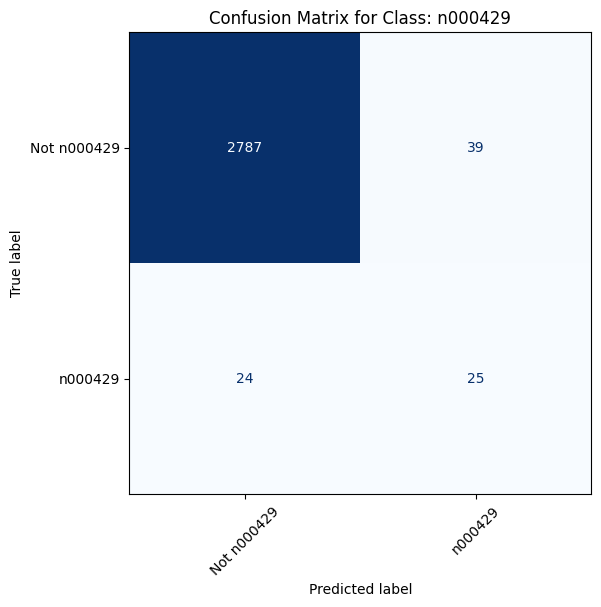

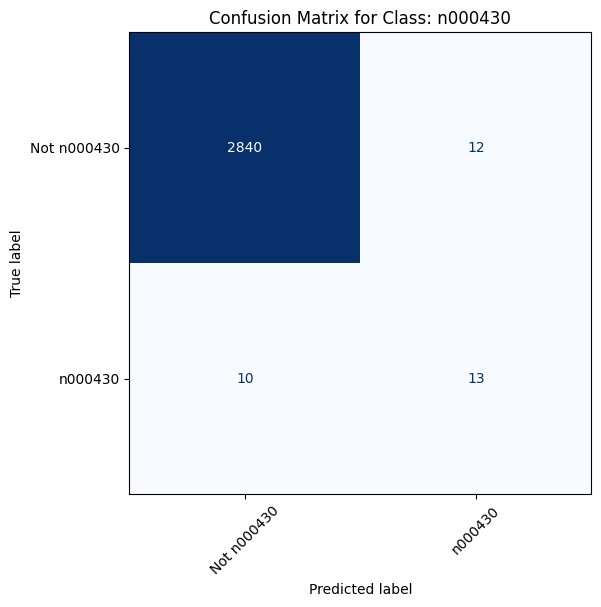

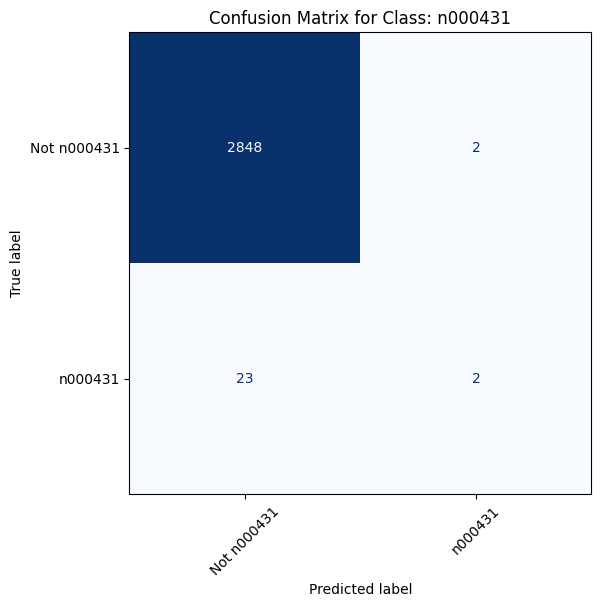

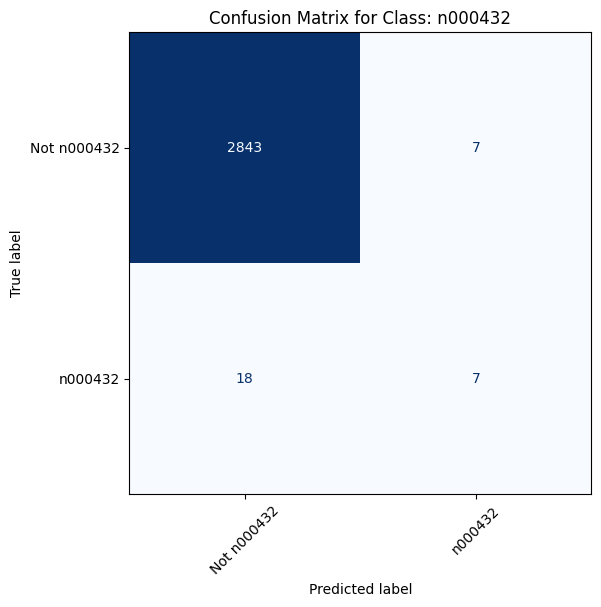

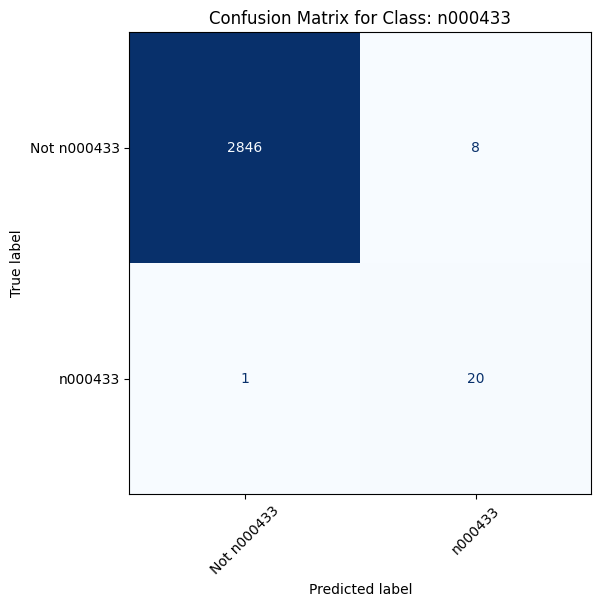

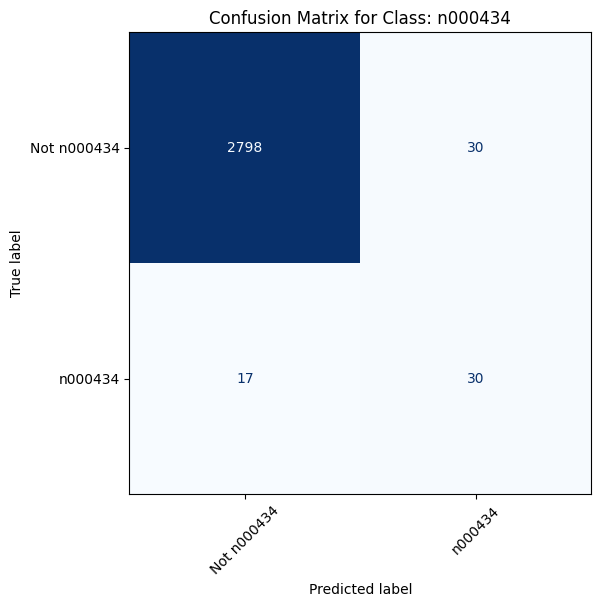

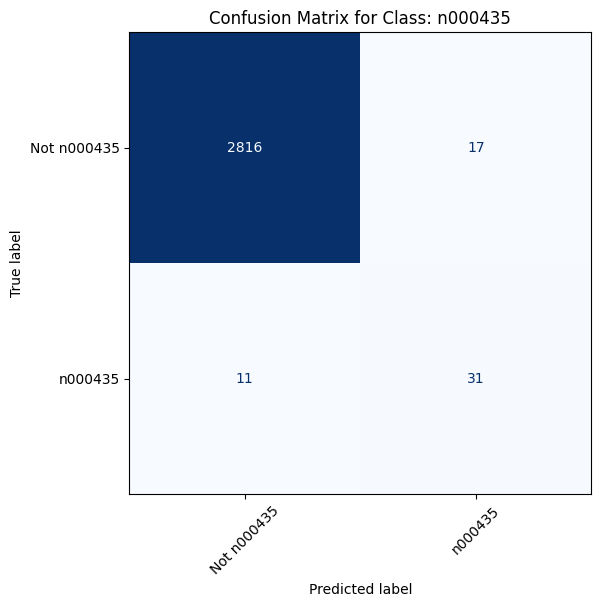

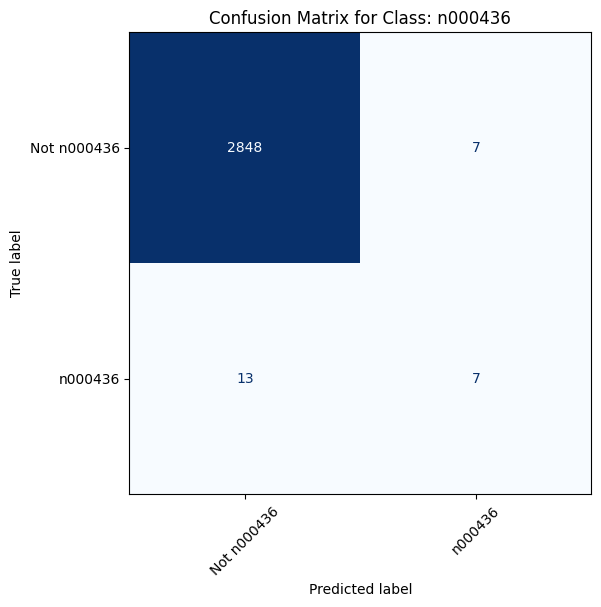

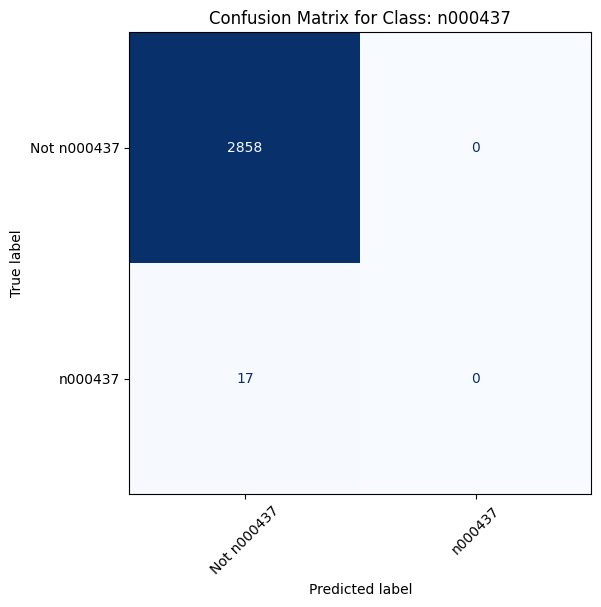

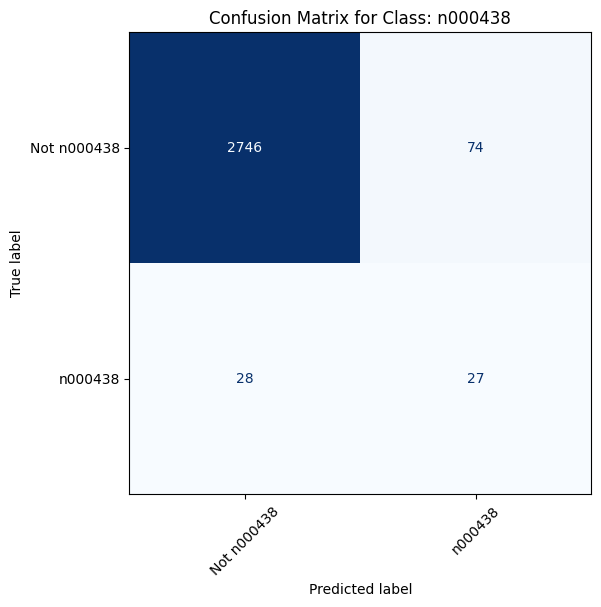

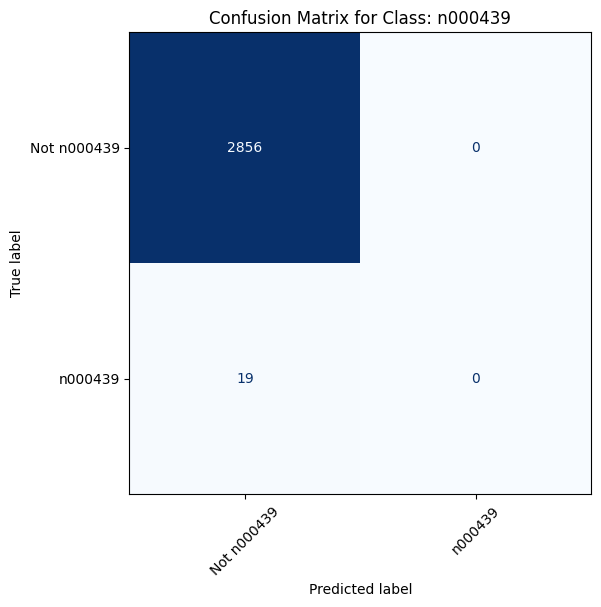

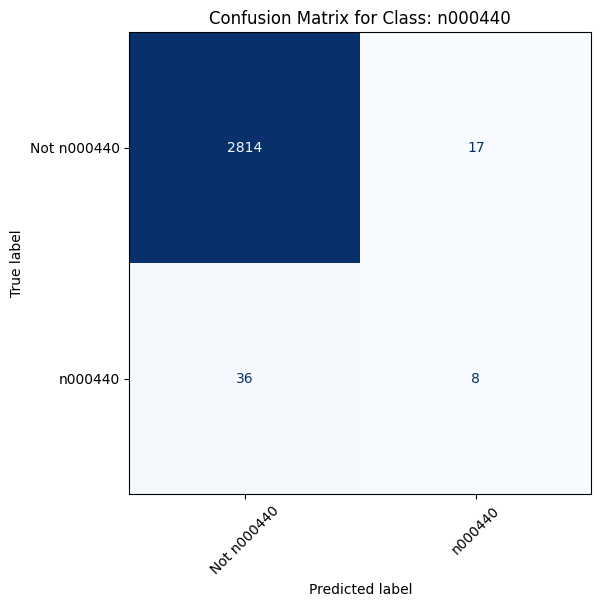

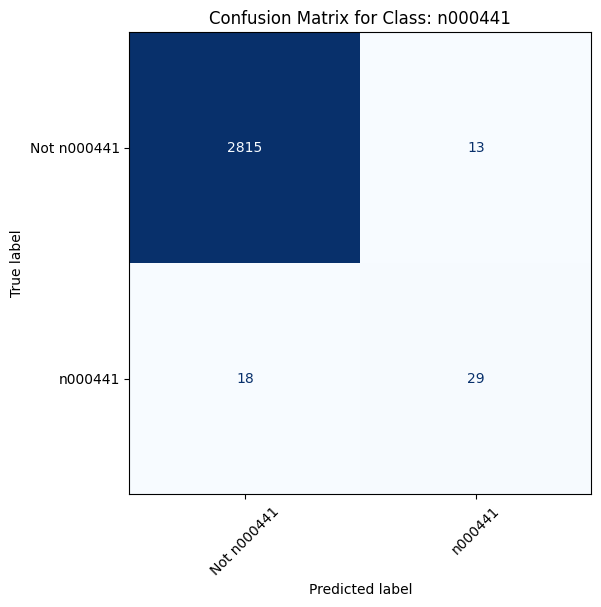

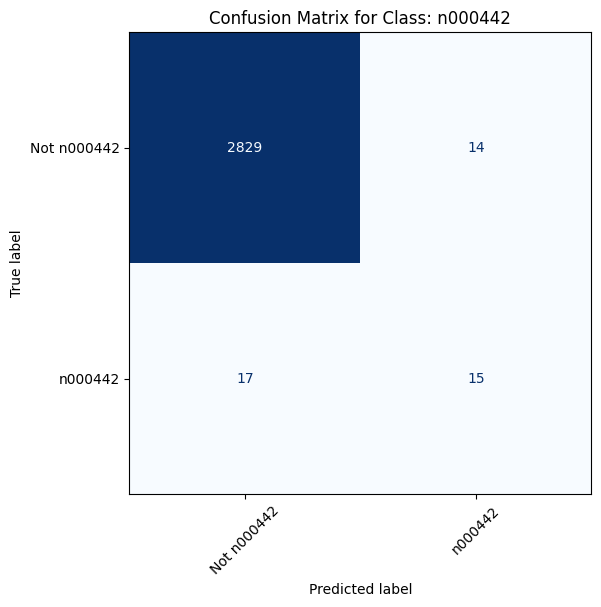

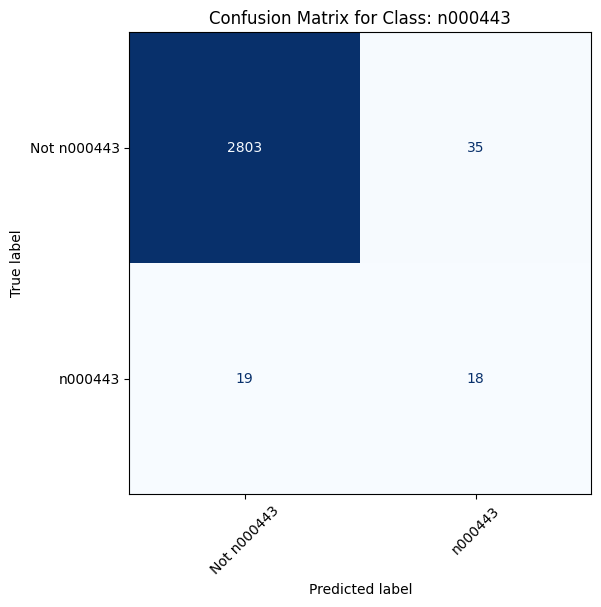

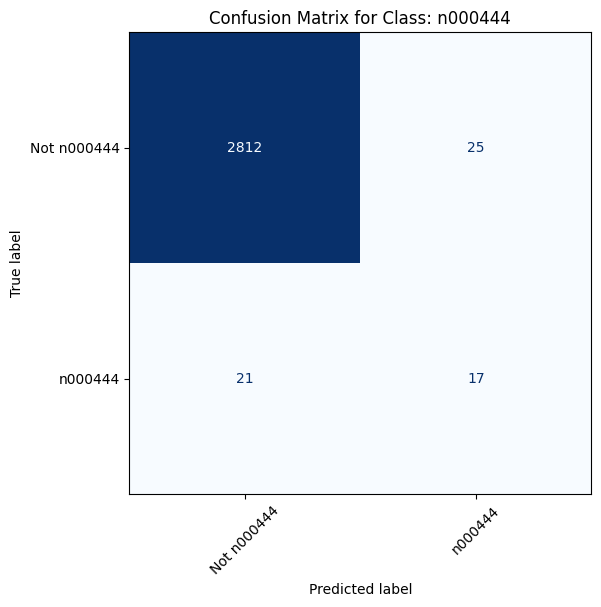

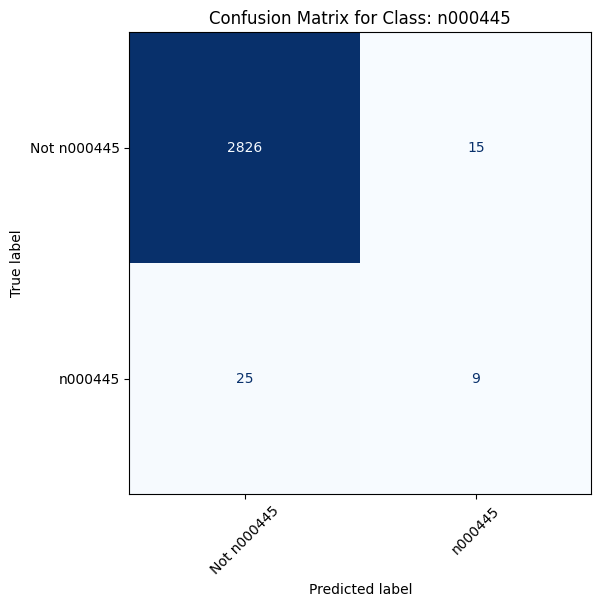

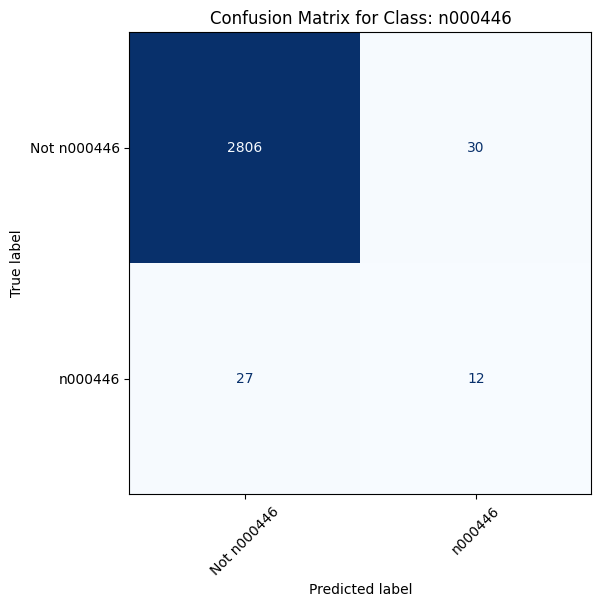

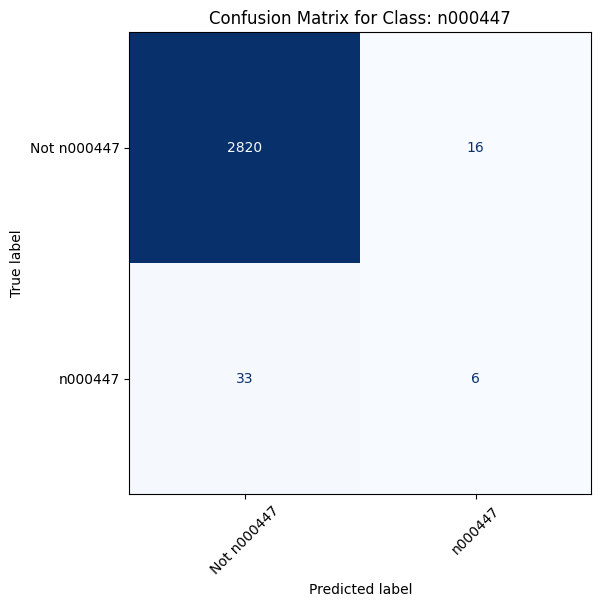

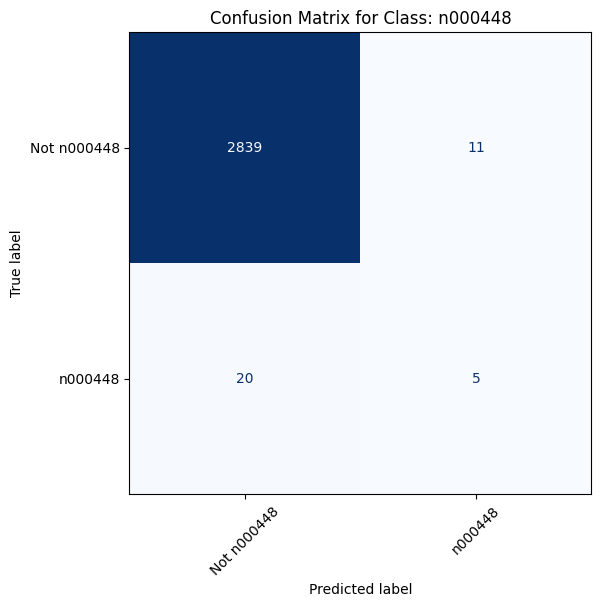

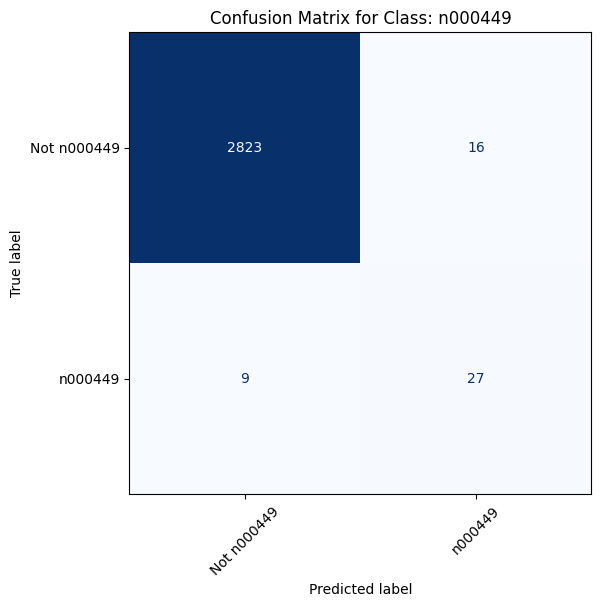

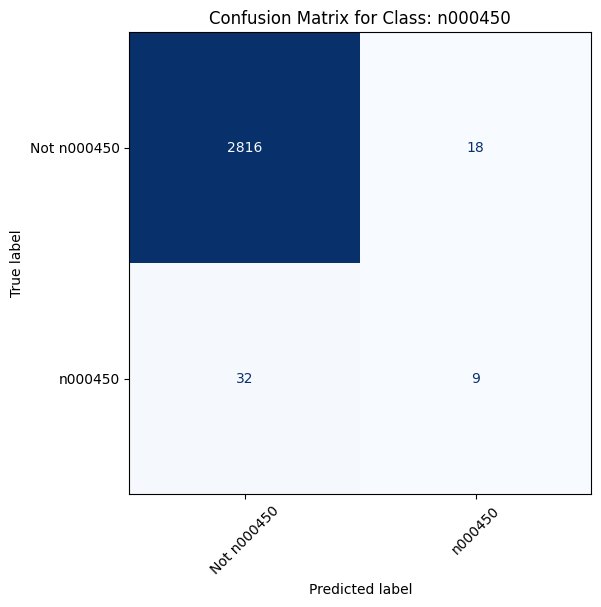

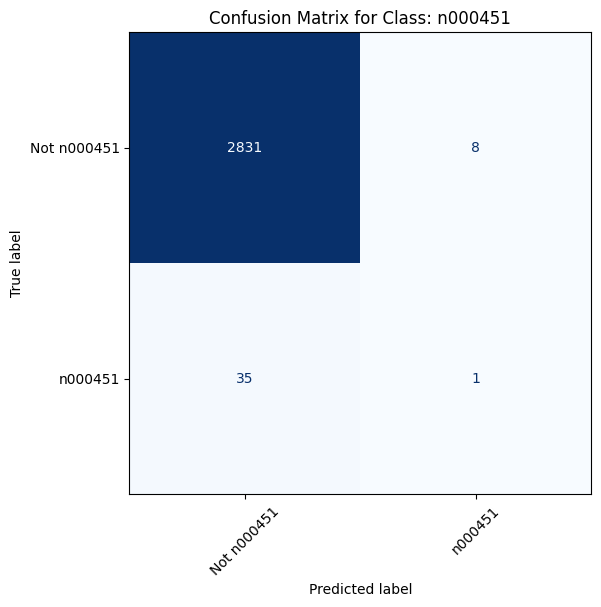

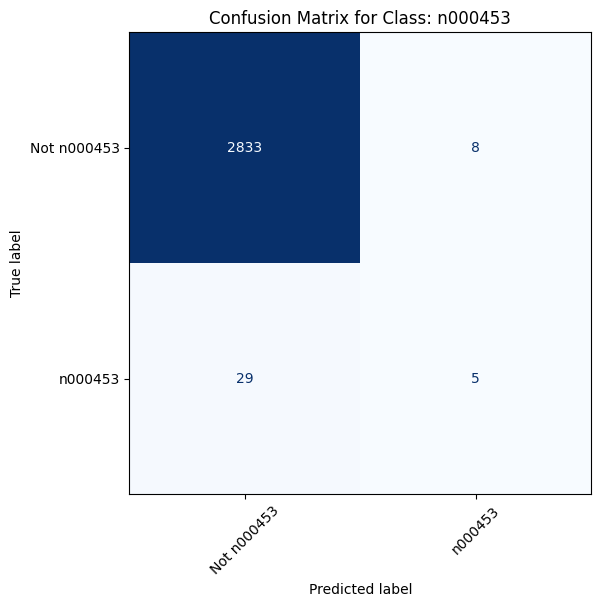

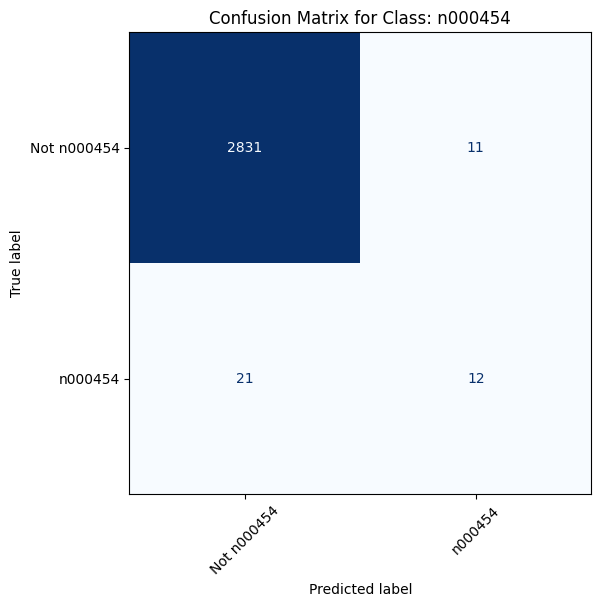

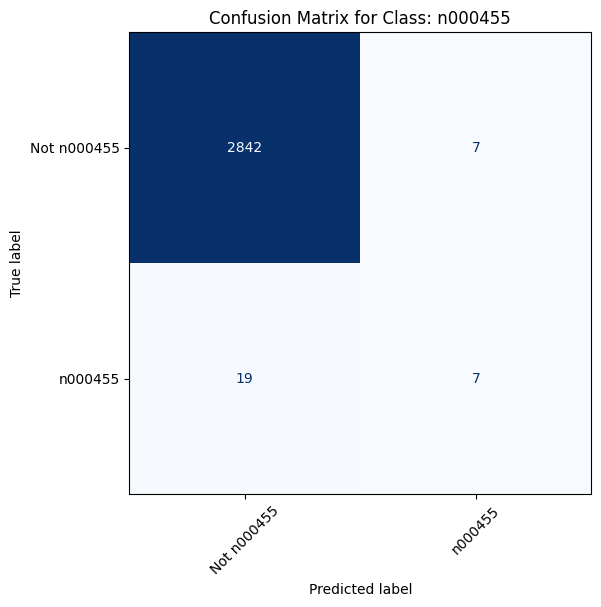

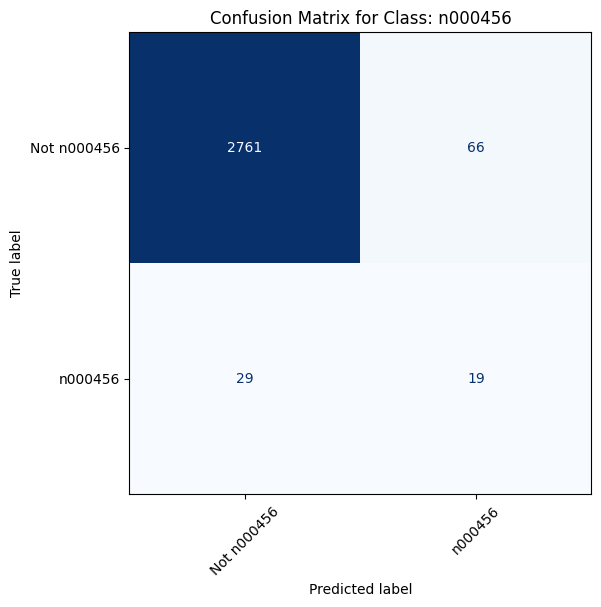

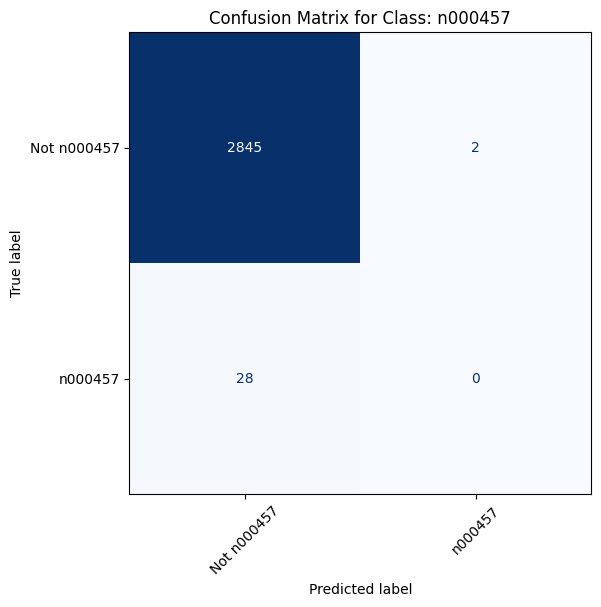

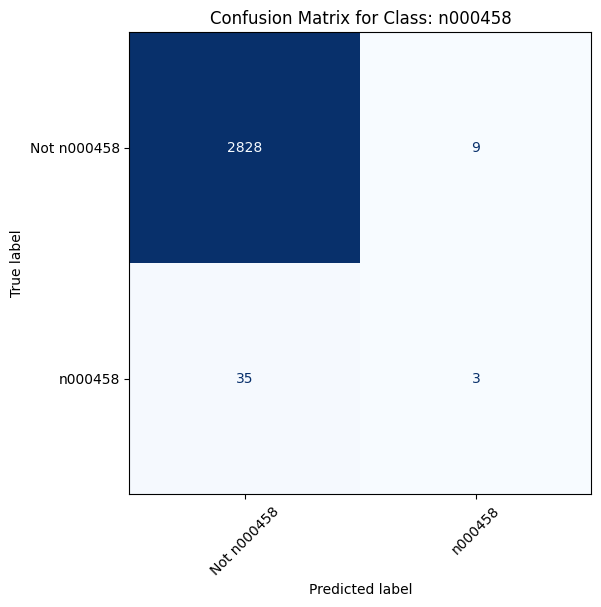

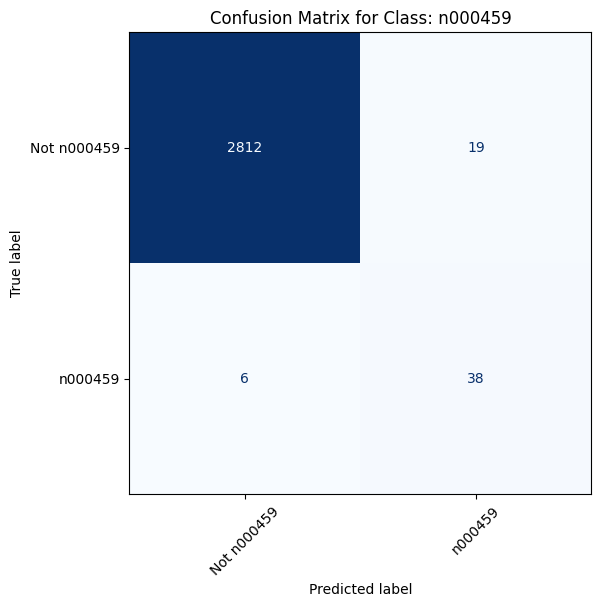

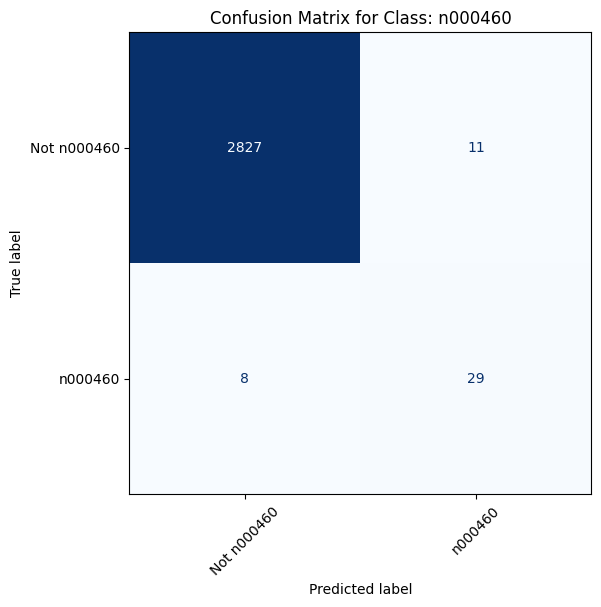

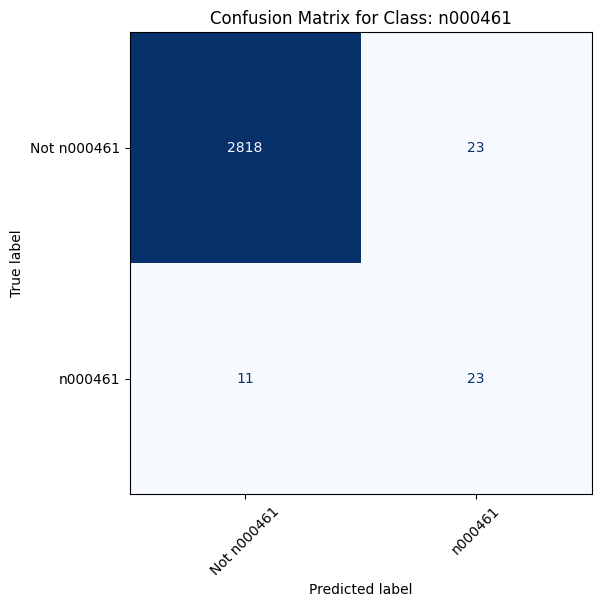

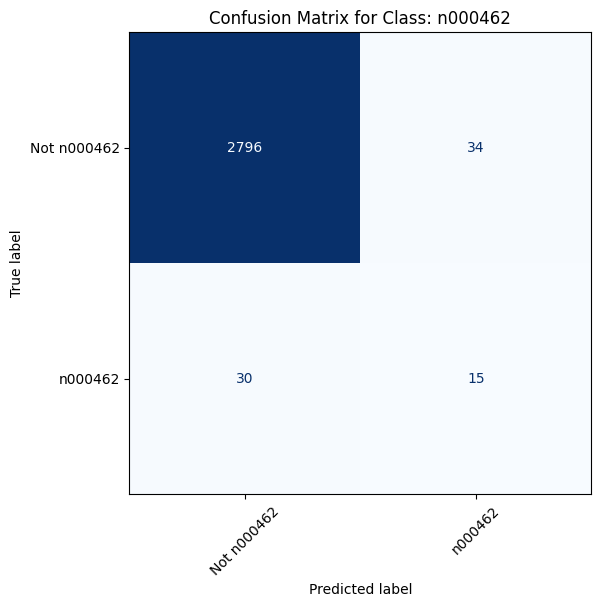

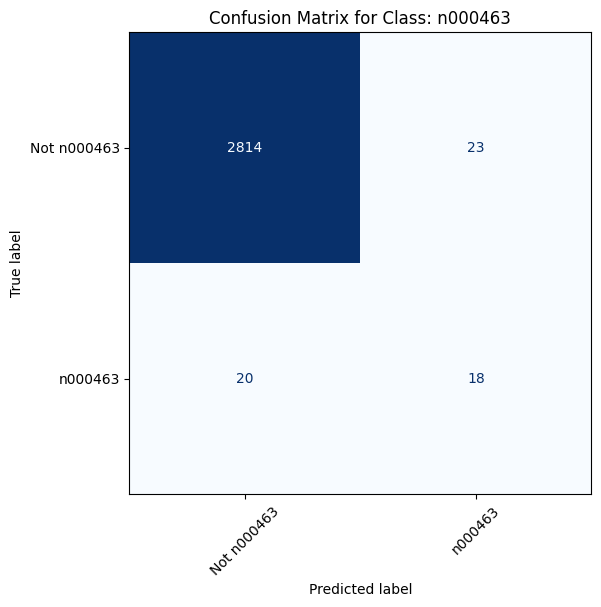

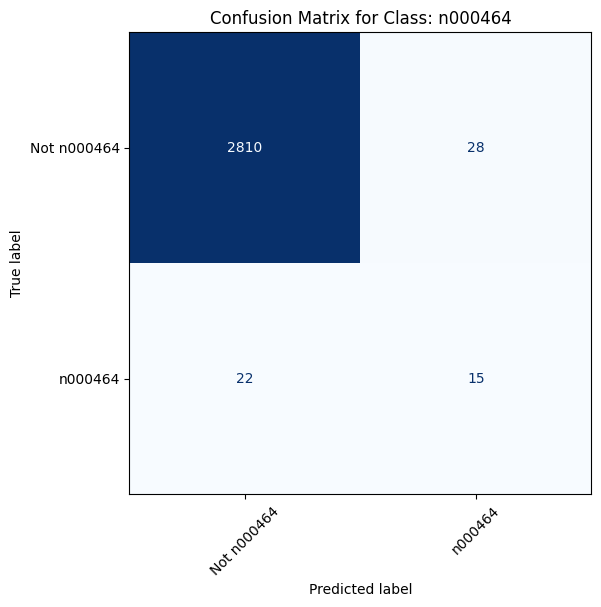

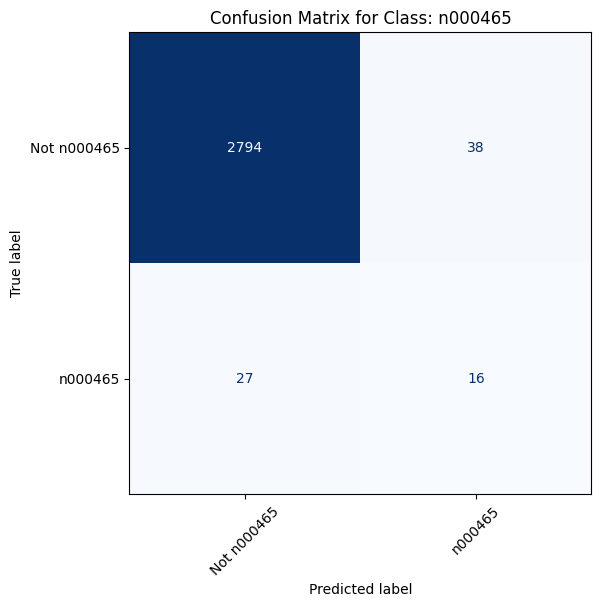

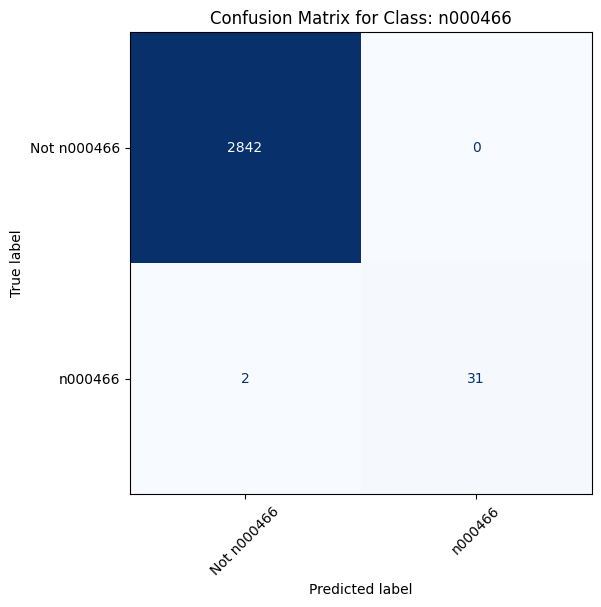

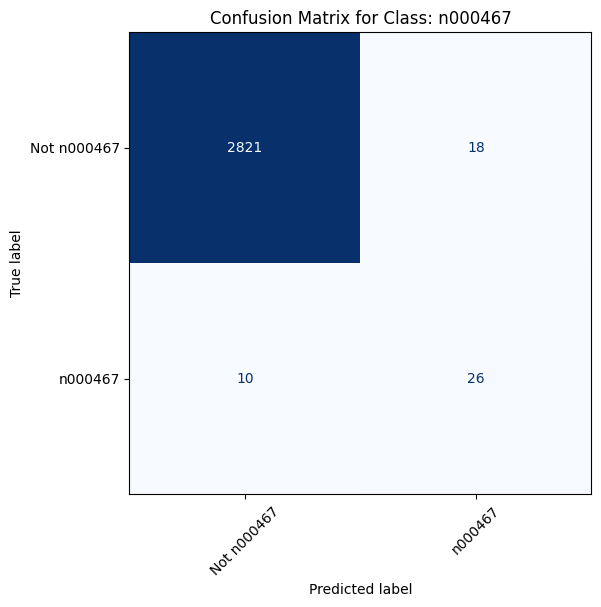

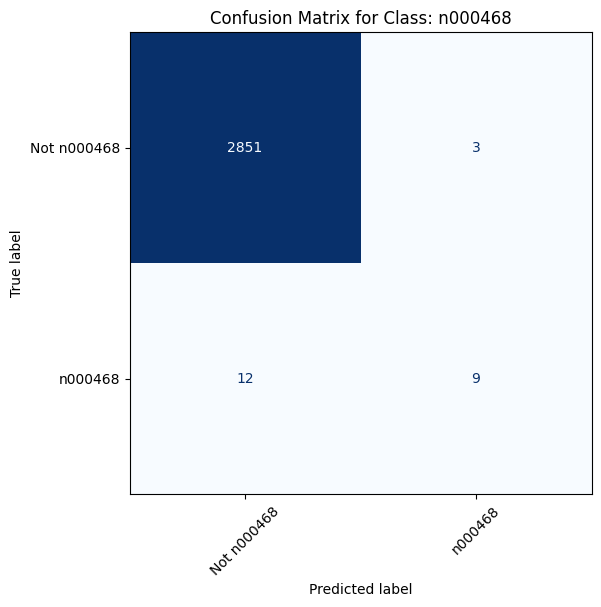

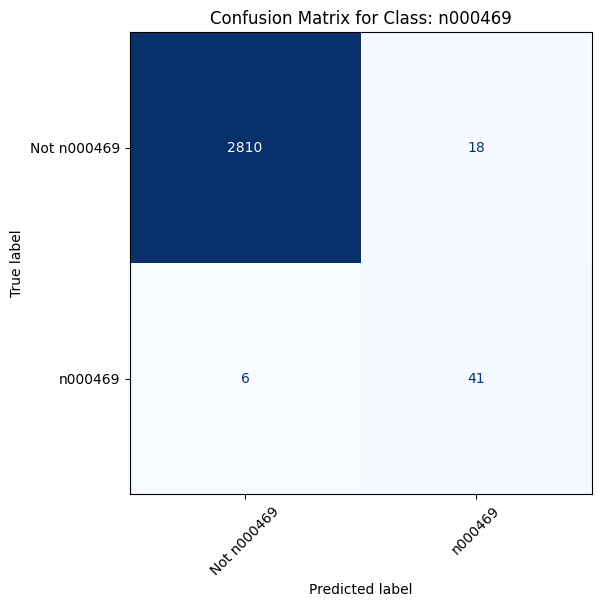

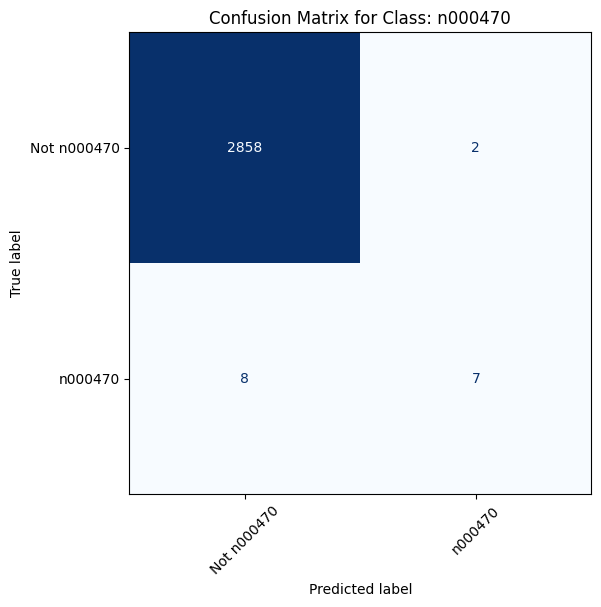

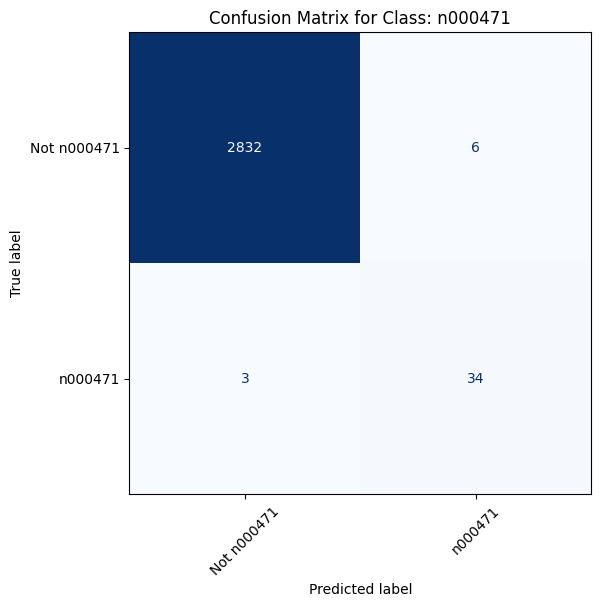

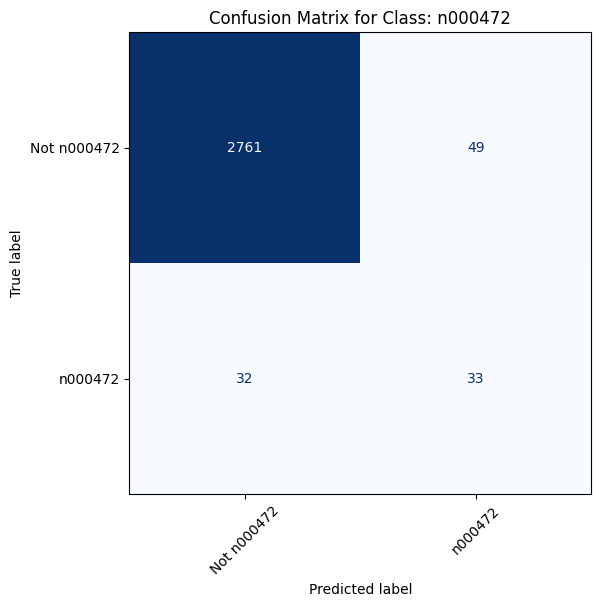

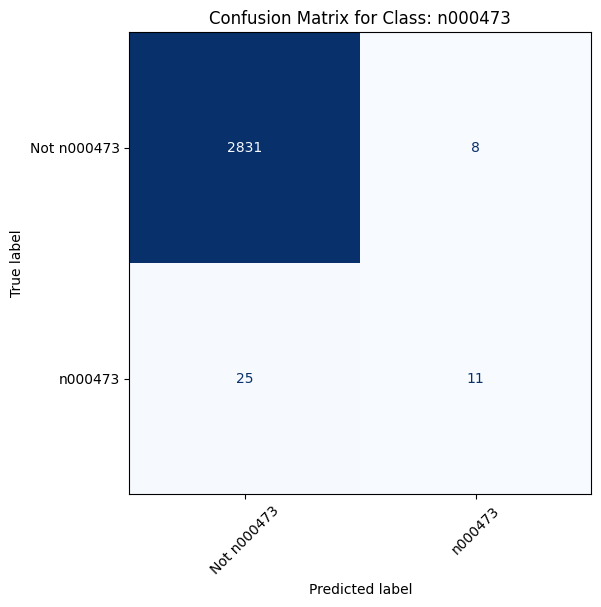

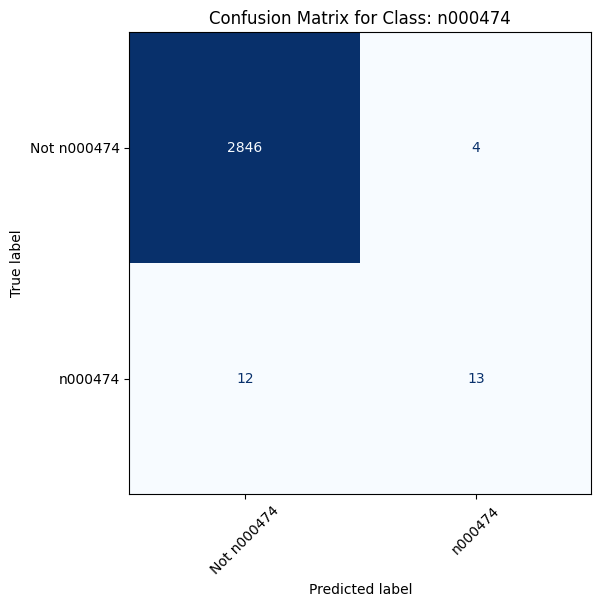

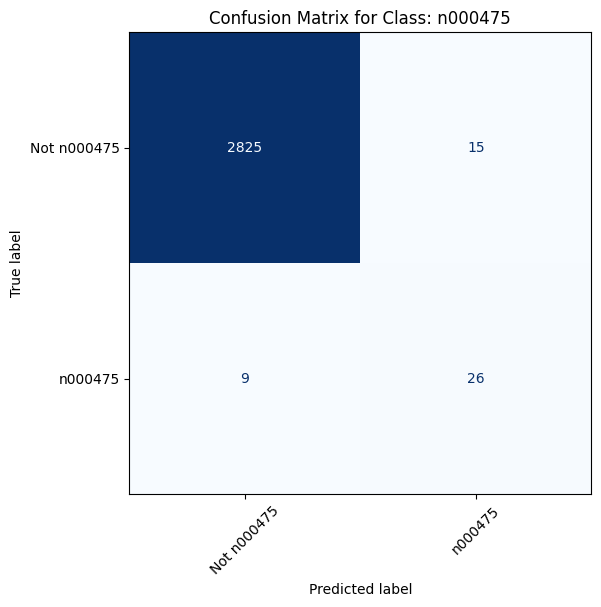

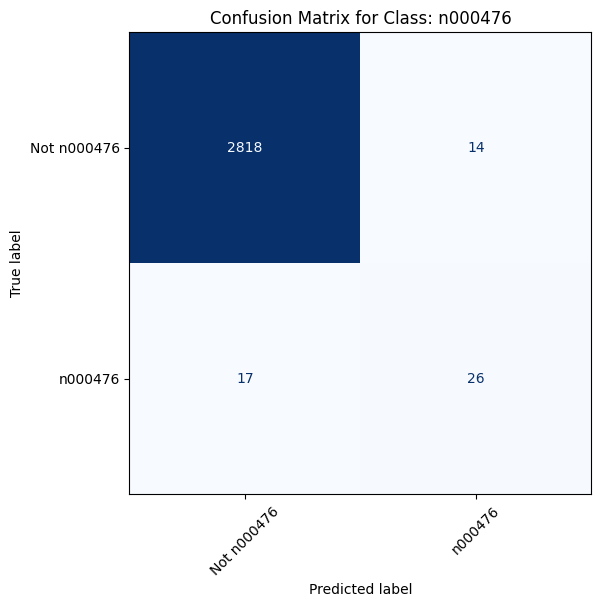

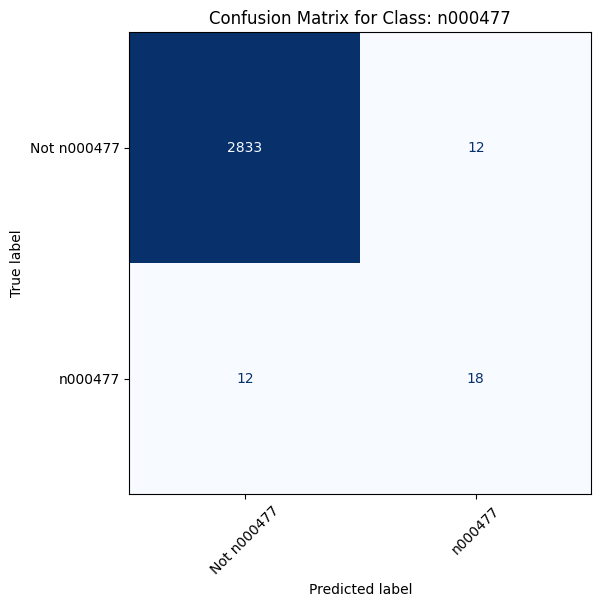

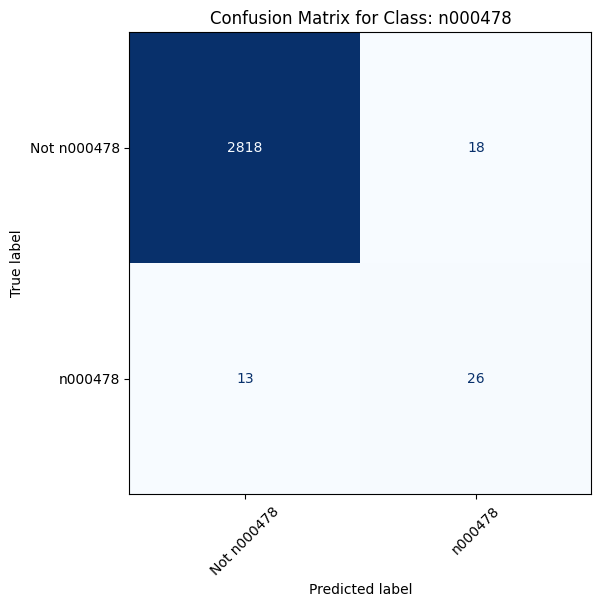

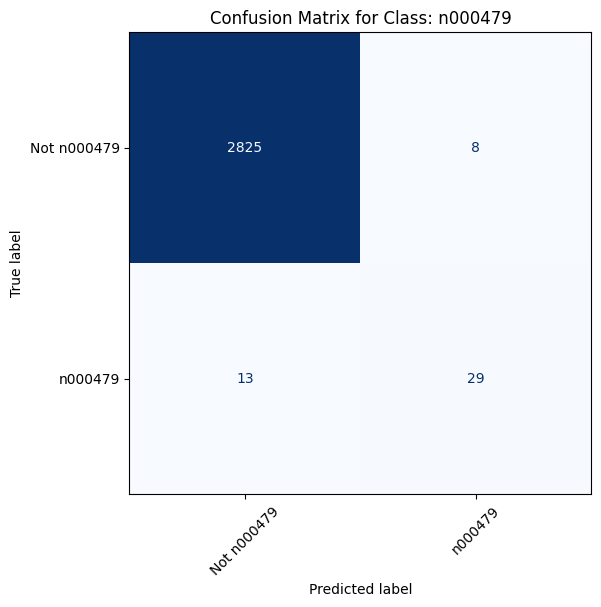

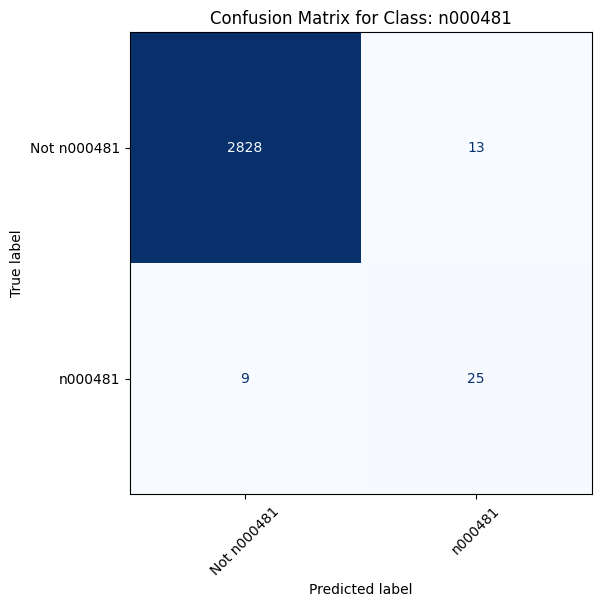

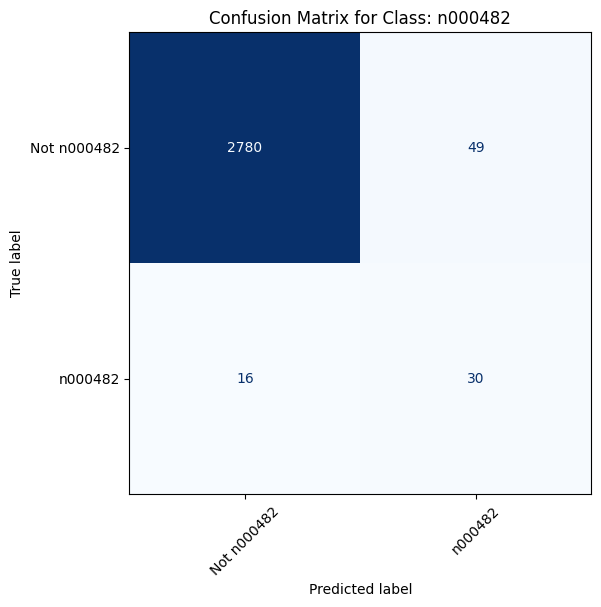

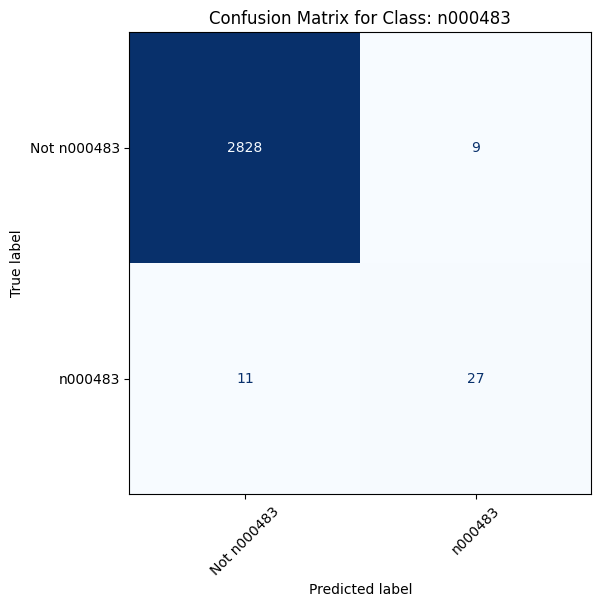

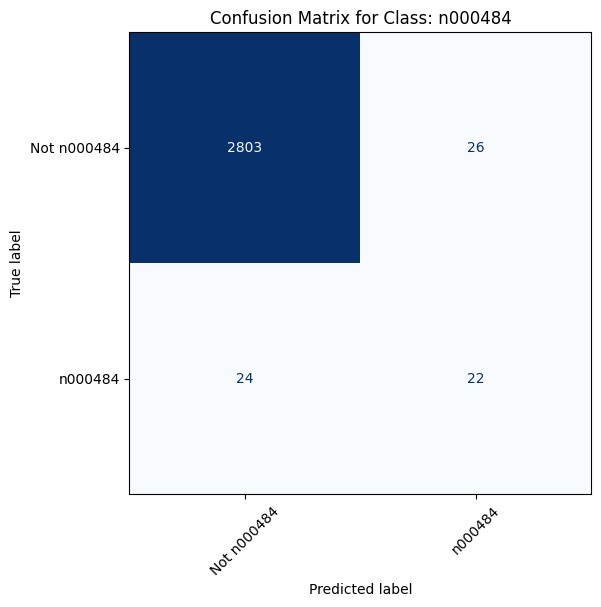

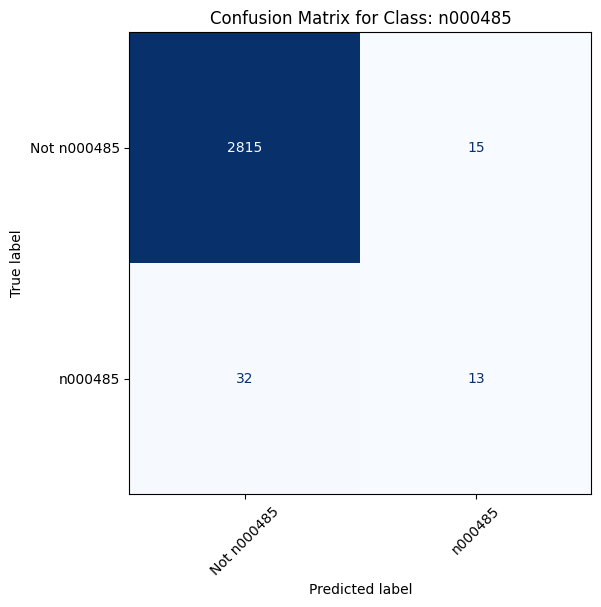

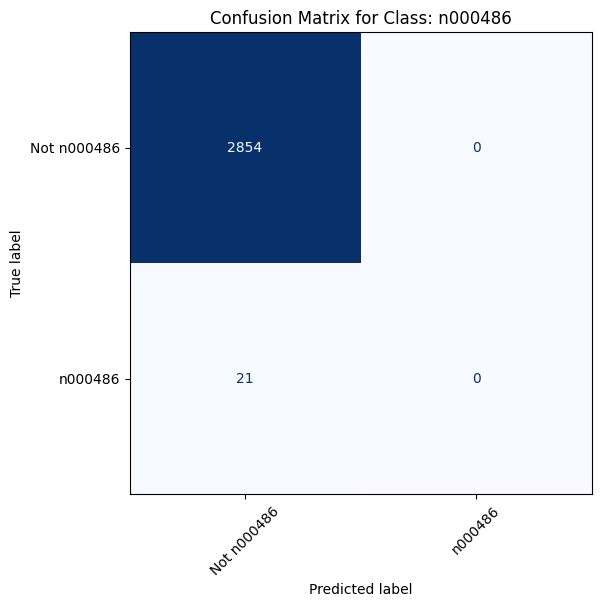

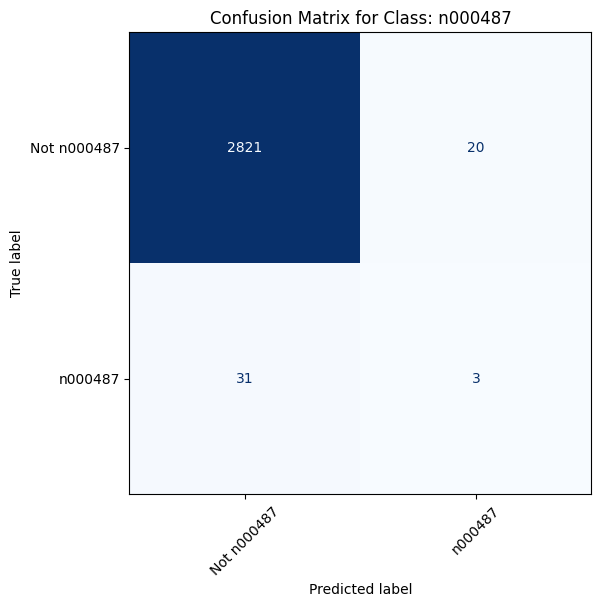

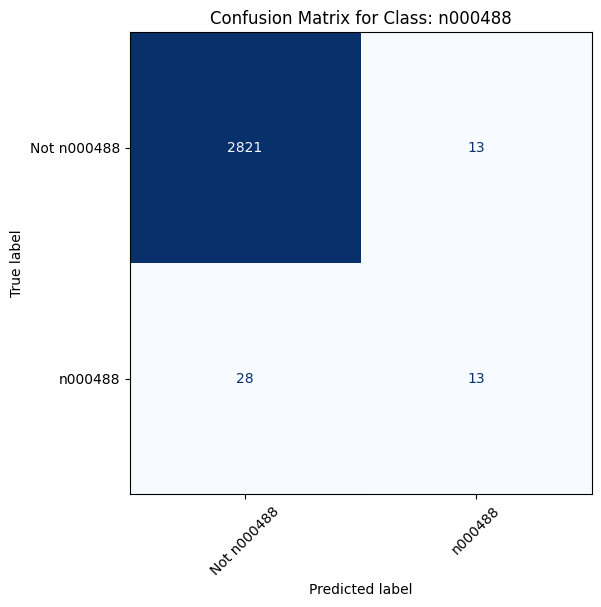

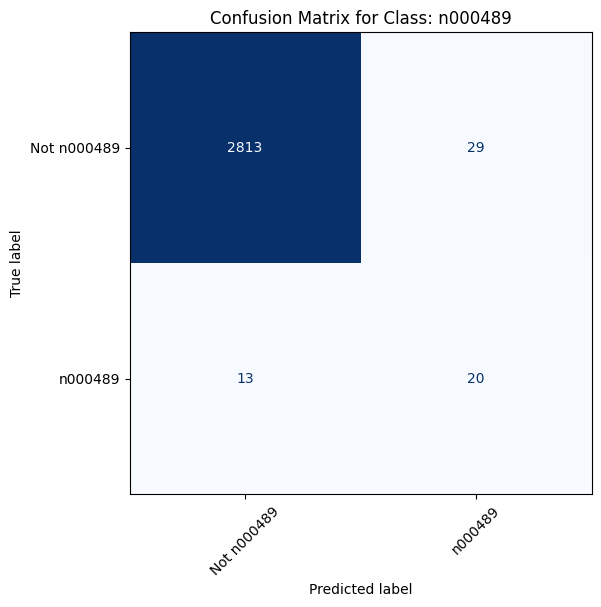

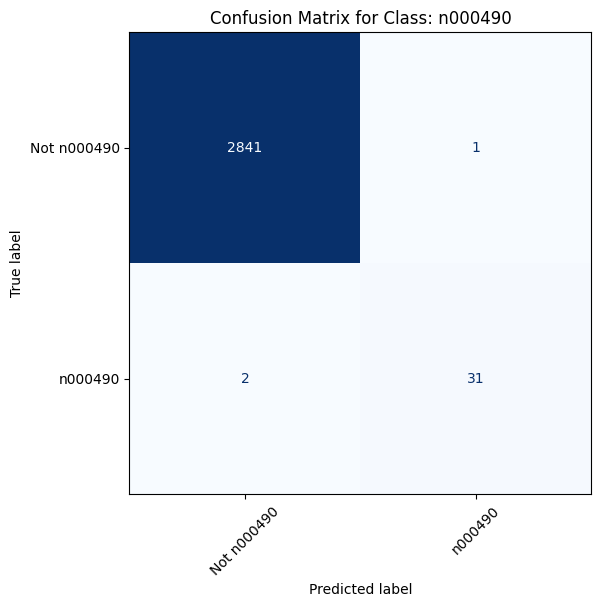

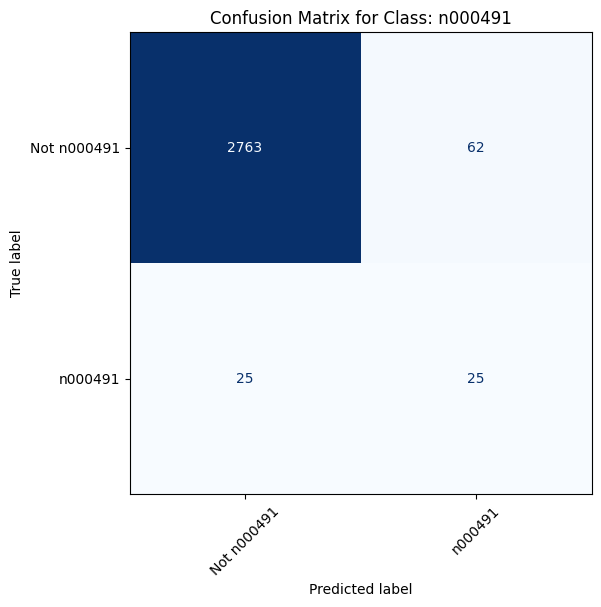

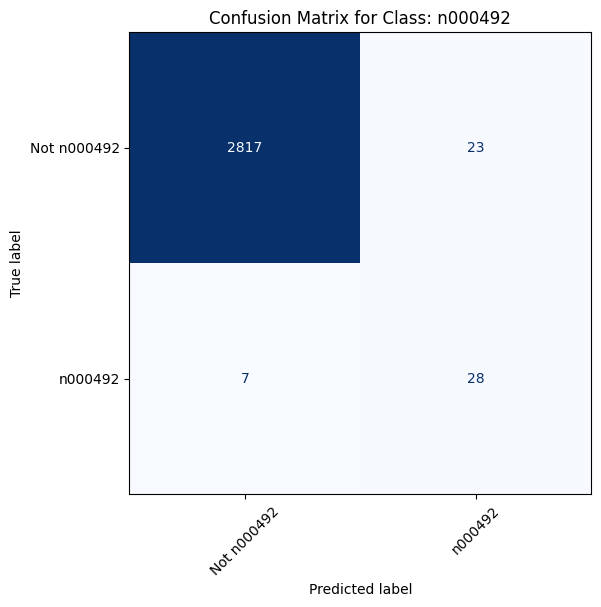

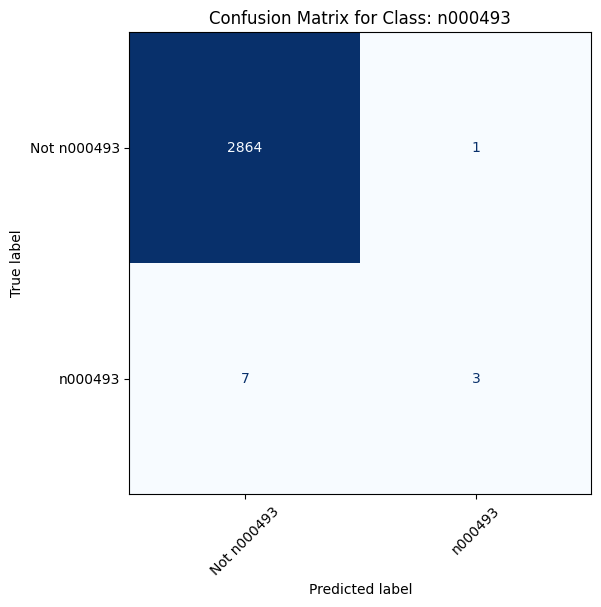

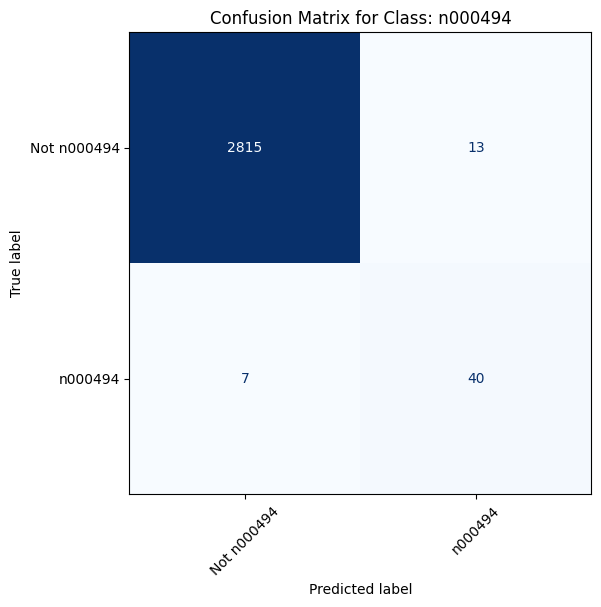

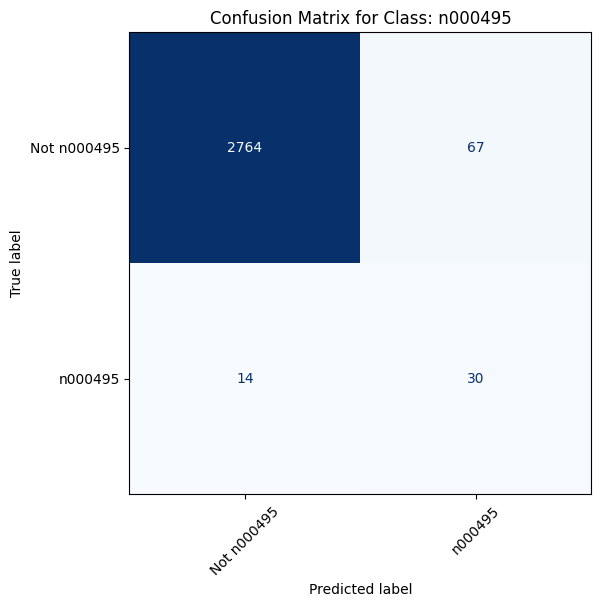

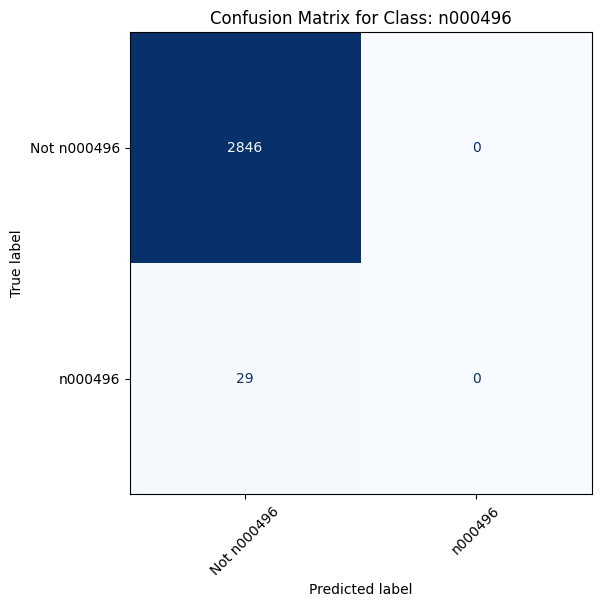

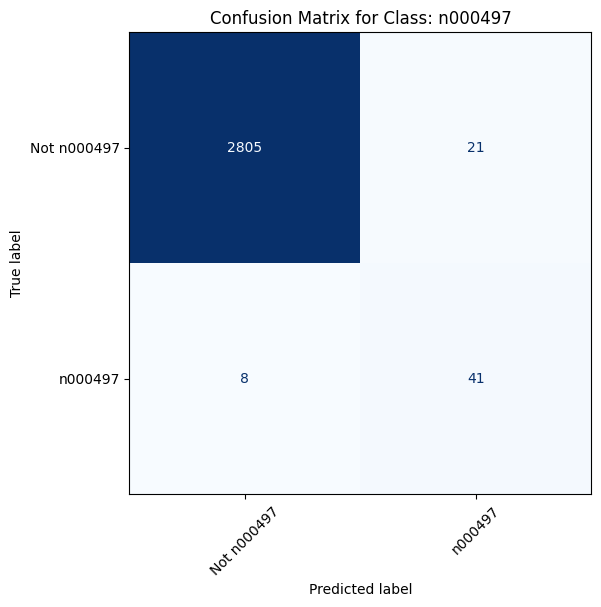

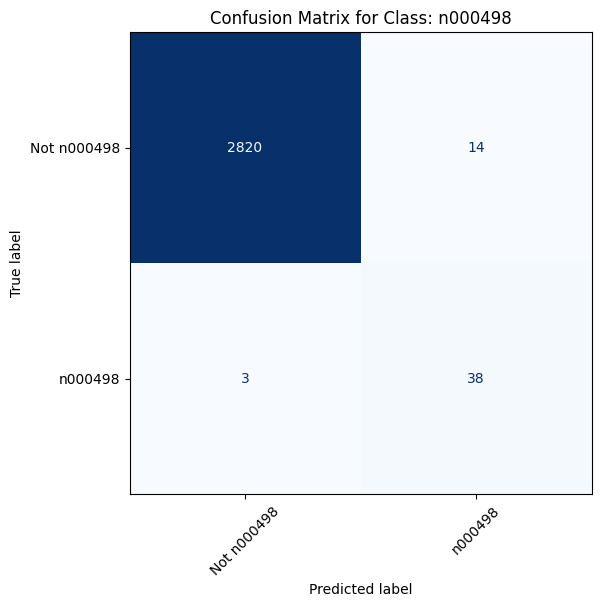

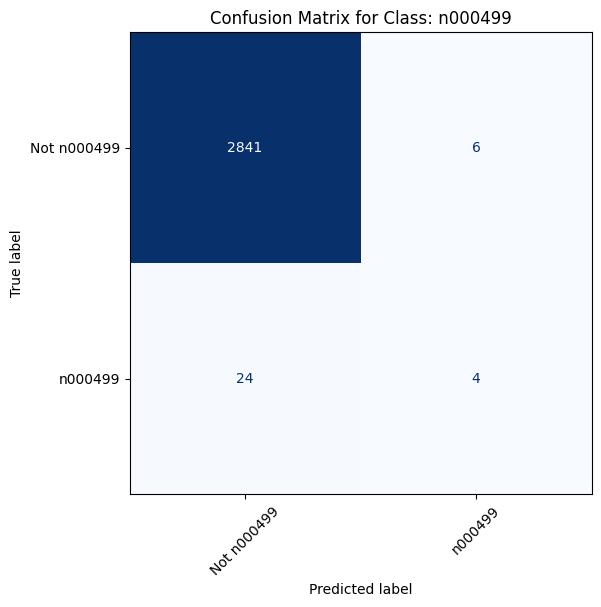

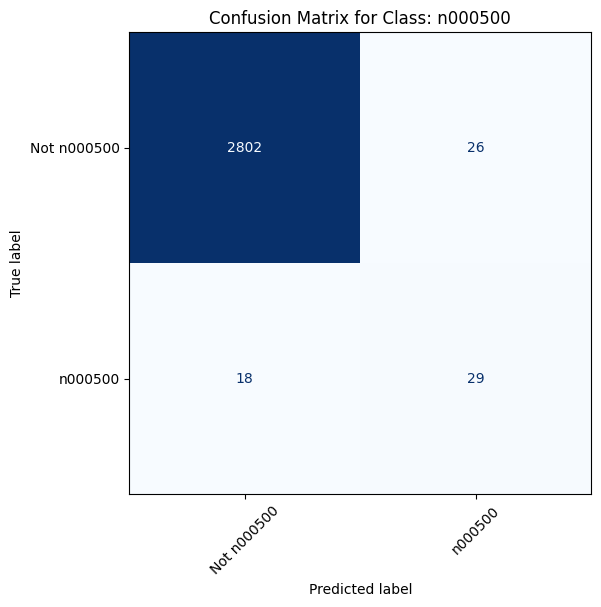

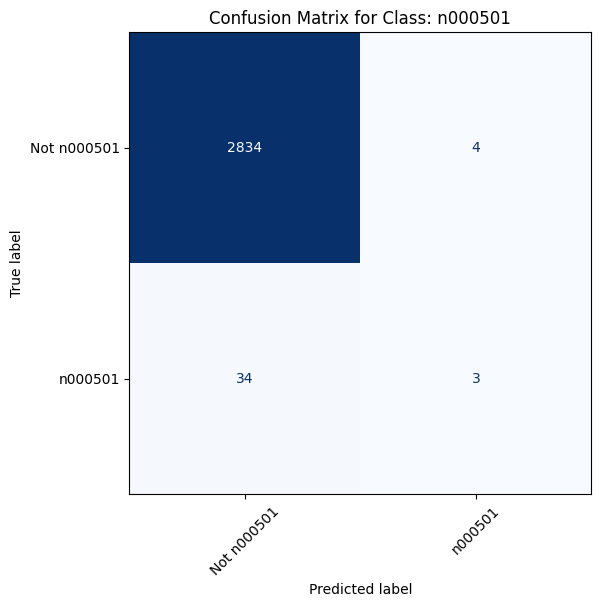

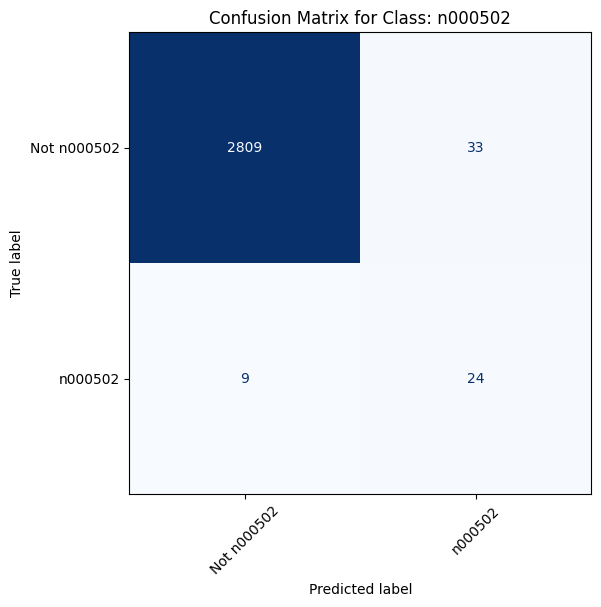

In [25]:

# one-vs-all confusion matrix
for i, class_label in enumerate(class_labels):
    # Binary true and predicted labels for one-vs-all
    y_true_binary = (y_true_classes == i).astype(int)
    y_pred_binary = (y_pred_classes == i).astype(int)

    # Compute confusion matrix
    cm_one_vs_all = confusion_matrix(y_true_binary, y_pred_binary)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_one_vs_all, display_labels=["Not " + class_label, class_label])
    disp.plot(cmap='Blues', ax=ax, colorbar=False)

    plt.title(f"Confusion Matrix for Class: {class_label}")
    plt.xticks(rotation=45)
    plt.show()